#### 0. Initial Setup

In [2]:
%%bash
pip install skflow

Cleaning up...


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gcp
import gcp.bigquery as bq
import skflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

In [4]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

#### 1. We define the following queries to obtain 500 risky customers and 500 not risky customers and their ratios from the first six use_cases:

In [5]:
%%sql --module trxn_pct_not_risk

DEFINE QUERY pct_table
SELECT *, 0 as HIGH_RISK FROM combined_test_set.PctTable WHERE ACCOUNTID NOT IN (SELECT ACCOUNTID FROM combined_test_set.TOP_529) limit 500

In [6]:
%%sql --module trxn_pct_risk

DEFINE QUERY pct_table
SELECT *, 1 as HIGH_RISK, FROM combined_test_set.PctTable WHERE ACCOUNTID IN (SELECT ACCOUNTID FROM combined_test_set.TOP_529) limit 500

#### 2. Convert SQL result to Python Dataframe:

In [7]:
#ratios of not risky customers (500)
not_risky = bq.Query(trxn_pct_not_risk.pct_table).to_dataframe()
#ratios of risky customers (500)
risky = bq.Query(trxn_pct_risk.pct_table).to_dataframe()

#### 3. A peek of what are the two tables look like:

In [149]:
#Ratios of not risky customers
#not_risky.shape
#not_risky

#Ratios of risky customers
#risky.shape
#risky

#### 4. Aggregate the two tables above to form a dataset and modify the dataframe to be ready for training and testing set:

In [8]:
sample_trans_wide = pd.concat([risky, not_risky])

In [9]:
sample_trans_wide = sample_trans_wide.drop('ACCOUNTID',1)
response = sample_trans_wide.HIGH_RISK

In [10]:
sample_trans_wide = sample_trans_wide.drop('HIGH_RISK', 1)

#### 5. Split training data and testing data:

In [11]:
t_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(sample_trans_wide, response, test_size=t_size, random_state=25)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#print 'Number of High Risk Customer in testing set:', sum(y_test)
#print 'Number of Low Risk Customer in testing set:', int(1000*t_size-sum(y_test))

((200, 9), (800, 9), (200,), (800,))


#### 6. Logistic Regression Model:

Training Accuracy:
0.84
Test Accuracy:
0.82625
Delta:
0.01375

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.70      0.80       407
          1       0.76      0.96      0.84       393

avg / total       0.85      0.83      0.82       800

Confusion Matrix:
[[285 122]
 [ 17 376]]


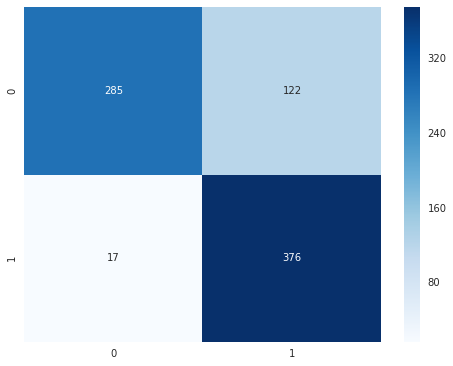

In [172]:
#A logistic classifier
classifier  = LogisticRegression()
classifier.fit(X_train, y_train)

#The Training accuracy and Test accuracy
print ("Training Accuracy:")
print (accuracy_score(y_train, classifier.predict(X_train)))
print ("Test Accuracy:")
print (accuracy_score(y_test, classifier.predict(X_test)))
print ("Delta:")
print accuracy_score(y_train, classifier.predict(X_train))-accuracy_score(y_test, classifier.predict(X_test))
#The Predictions from training data and testing data
predictions = classifier.predict(X_train)
y_pred = classifier.predict(X_test)

#Classification Report
print
print ("Classification Report:")
print metrics.classification_report(y_test, y_pred)

#Confusion Matrix and Heatmap
print ("Confusion Matrix:")
log_matrix = metrics.confusion_matrix(y_test, y_pred)
print log_matrix


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(log_matrix,annot=True,cmap = 'Blues',ax = ax,fmt = 'g')

#### 7. Random Forest Model:

Accuracy Score for training:
0.995
Accuracy Score for test:
0.86
Delta:
0.135

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.82      0.86       407
          1       0.83      0.90      0.86       393

avg / total       0.86      0.86      0.86       800

Confusion Matrix:
[[334  73]
 [ 39 354]]


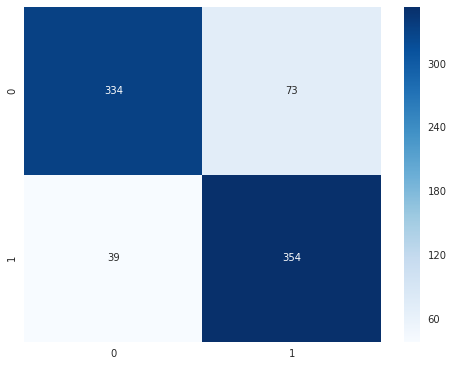

In [170]:
#A random forest with 20 trees
classifier = RandomForestClassifier(n_estimators = 20)
classifier.fit(X_train, y_train)

#print(sorted(classifier.feature_importances_, reverse = True)[1:10])
#The Training accuracy and Test accuracy
print("Accuracy Score for training:")
print accuracy_score(y_train, classifier.predict(X_train))
print("Accuracy Score for test:")
print accuracy_score(y_test, classifier.predict(X_test))
print("Delta:")
print accuracy_score(y_train, classifier.predict(X_train))-accuracy_score(y_test, classifier.predict(X_test))
print

#Prediction from testing data
y_pred = classifier.predict(X_test)

#Classification Report
print("Classification Report")
print metrics.classification_report(y_test, y_pred)

#Confusion Matrix and Heatmap
print ("Confusion Matrix:")
log_matrix = metrics.confusion_matrix(y_test, y_pred)
print log_matrix


fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(log_matrix,annot=True,cmap = 'Blues',ax = ax,fmt = 'g')